# Exploratory Data Analysis of the Divvy bikeshare dataset

## 1. Problem Overview

Divvy is a bikeshare service based in Chicago. Paying customers can rent bikes from Divvy at one of the many available bike distribution centers (the origin), ride the bike as required, and then return the bike at a bike distribution center (the destination). For each bike ride, Divvy provides a set of features associated with the transaction and these are publicly available. 

The overall objective of this analysis is to create a model that can predict whether a bike trip will be short (less than 2 km) or not. Note that 2 km is about 1.2 miles. In Chicago, there are about 8 blocks per mile. So, 2 km is approximately 10 blocks. The model is expected to predict whether a bike ride will go as far as approximately 10 blocks or less. 

<B> Why is such a model useful?  </B>

A key problem with bike sharing is that the number of bike rides from a point of origin to a destination is typically not the same as the number of bike rides from the destination to the point of origin. A consequence of this asymmetry is that the number of available bikes available at the point of origin or destination is diminished. In this case, the number of available bikes at a distribution center has to be rebalanced by trucking the bikes back and forth to avoid depletion of number of available bikes. Starting with an origin site, a model for the length of the ride can be used to predict which nearby destination center is likely to acquire a bike. Based on usage patterns, Divvy can estimate how often and how many bikes have to be transferred back to the origin site. Another application of the model would be to estimate how often bikes have to be repaired or upgraded. Short trips are likely to cause less wear and tear on the bike compared to a longer trip. Of course, a large number of short trips can also cause enough wear-and-tear on the bike. So, predictions for the trip length as well as trip counts are useful for estimating maintainence needs.

## 2. Exploring the data

The objective of the exploratory data analysis presented here is to understand the nature of the data provided by Divvy, i.e., the distribution of features, correlations between pairs of features, and possible correlation of the features with the length of the bike trip. Based on such an analysis, features relevant for constructing a model for predicting the trip length of a bike rental can be identified or engineered. 

### 2.1. Data acquisition and organization

The Divvy website provides a link to the bike ride data (https://www.divvybikes.com/system-data) for each starting year starting with 2013 when Divvy started providing their bikeshare service up to 2017. For each year, Divvy releases bikeshare data for Quarters 1 and 2 at the end of the second quarter, and for Quarters 3 and 4 at the end of the fourth quarter. Data for 2018 is likely to be made public in a few months. 

All data from 2014 to 2017 was downloaded as zipped files that were inflated and the reorganized into directories renamed Divvy_Trips_YYYY_QiQj, where YYYY is the year and QiQj are (i,j) = (1,2) for Quarters 1 and 2, and (i,j) = (3,4) for Quarters 3 and 4. All the data directories are saved in a directory named input and can be listed as shown below

In [1]:
# Import all libraries
import os
import warnings
warnings.filterwarnings('ignore')
import math
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
%matplotlib inline
import pickle

In [2]:
root1 = "../input/"
dirlist1 = [os.path.join(root1, f) for f in os.listdir(root1)]
print(dirlist1)

['../input/Divvy_Trips_2014_Q1Q2', '../input/Divvy_Trips_2014_Q3Q4', '../input/Divvy_Trips_2015-Q1Q2', '../input/Divvy_Trips_2015_Q3Q4', '../input/Divvy_Trips_2016_Q1Q2', '../input/Divvy_Trips_2016_Q3Q4', '../input/Divvy_Trips_2017_Q1Q2', '../input/Divvy_Trips_2017_Q3Q4']


To find out how the data has been provided, lets look at the contents of each data directory as follows

In [3]:
filelist1 = [os.path.join(x,y).replace('\\','/') for x in dirlist1 for y in os.listdir(x)]
filelist1

['../input/Divvy_Trips_2014_Q1Q2/Divvy_Stations_2014-Q1Q2.xlsx',
 '../input/Divvy_Trips_2014_Q1Q2/Divvy_Trips_2014_Q1Q2.csv',
 '../input/Divvy_Trips_2014_Q1Q2/README.txt',
 '../input/Divvy_Trips_2014_Q3Q4/Divvy_Stations_2014-Q3Q4.csv',
 '../input/Divvy_Trips_2014_Q3Q4/Divvy_Trips_2014-Q3-07.csv',
 '../input/Divvy_Trips_2014_Q3Q4/Divvy_Trips_2014-Q3-0809.csv',
 '../input/Divvy_Trips_2014_Q3Q4/Divvy_Trips_2014-Q4.csv',
 '../input/Divvy_Trips_2014_Q3Q4/README.txt',
 '../input/Divvy_Trips_2015-Q1Q2/Divvy_Stations_2015.csv',
 '../input/Divvy_Trips_2015-Q1Q2/Divvy_Trips_2015-Q1.csv',
 '../input/Divvy_Trips_2015-Q1Q2/Divvy_Trips_2015-Q2.csv',
 '../input/Divvy_Trips_2015_Q3Q4/Divvy_Trips_2015_07.csv',
 '../input/Divvy_Trips_2015_Q3Q4/Divvy_Trips_2015_08.csv',
 '../input/Divvy_Trips_2015_Q3Q4/Divvy_Trips_2015_09.csv',
 '../input/Divvy_Trips_2015_Q3Q4/Divvy_Trips_2015_Q4.csv',
 '../input/Divvy_Trips_2016_Q1Q2/Divvy_Stations_2016_Q1Q2.csv',
 '../input/Divvy_Trips_2016_Q1Q2/Divvy_Trips_2016_04.csv

The Divvy datasite informs us that the Trips file contains data for all bike trips in a given quarter (or month) whereas the Stations file contains the list of bike stations in operation during a given quarter (or month).

The trips data is provided in one csv format file for each quarter of 2017. However, in 2016, the Q2 Trips data is split into multiple csv files, Trips_2016_X.csv, where X = 04, 05, and 06. Clearly, the data for three months was not combined into one data file for the second quarter. The same split can be seen for 2014_Q3Q4, 2015_Q3. In 2014, the Q1 and Q2 data was combined into one file. So there is some inconsistency in how the data for each year and each quarter is provided. However, the consistent use of CSV data is helpful.

The Stations data is provided in csv format for all years except for 2014 where an XLSX file is provided for Q1Q2. Looks like the data team decided to be consistent in their use of the csv format. In 2017, the stations data for Q1 and Q2, as well as Q3 and Q4 are combined into one file for each pair of quarters. In 2016 for Q3 and Q4, separate files are provided, one for each quarter, although Q1 and Q2 station data is in the same file. These differences in file naming probably indicates changes in the number of Stations between Q3 and Q4. 

In each directory, a README.txt file is provided and it contains metadata for the Trips and Stations file.

### 2.2. Trips Data

#### 2.2.1. Loading the trips data

Now lets explore the Trips data for 2017. In 2017, a single csv file for each pair of quarters is provided. So, lets read in both and save them to a single dataframe for further analysis.

In [4]:
trips2017q4 = pd.read_csv(filelist1[len(filelist1)-2])
trips2017q3 = pd.read_csv(filelist1[len(filelist1)-3])
trips2017q2 = pd.read_csv(filelist1[len(filelist1)-6])
trips2017q1 = pd.read_csv(filelist1[len(filelist1)-7])
trips2017 = pd.concat([trips2017q1, trips2017q2, trips2017q3, trips2017q4], axis=0)
trips2017.sort_values(by='trip_id', ascending=True, inplace=True)
trips2017['start_time'] = pd.to_datetime(trips2017['start_time'])
trips2017['end_time'] = pd.to_datetime(trips2017['end_time'])
trips2017.head(5)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
431690,12979230,2017-01-01 00:00:36,2017-01-01 00:06:32,2511,356,414,Canal St & Taylor St,191,Canal St & Monroe St (*),Customer,NaN,NaN
431689,12979231,2017-01-01 00:02:54,2017-01-01 00:08:21,3660,327,28,Larrabee St & Menomonee St,20,Sheffield Ave & Kingsbury St,Subscriber,Male,1984.0
431688,12979232,2017-01-01 00:06:06,2017-01-01 00:18:31,4992,745,620,Orleans St & Chestnut St (NEXT Apts),333,Ashland Ave & Blackhawk St,Subscriber,Male,1985.0
431687,12979233,2017-01-01 00:07:28,2017-01-01 00:12:51,5637,323,287,Franklin St & Monroe St,68,Clinton St & Tilden St,Subscriber,Male,1990.0
431686,12979234,2017-01-01 00:07:57,2017-01-01 00:20:53,2209,776,300,Broadway & Barry Ave,118,Sedgwick St & North Ave,Subscriber,Male,1990.0


#### 2.2.2 How many trips are in the dataset?

So far only trips for 2017 were considered. From the point of view of modeling the data, it is important to know how much data is available.

In [5]:
len(trips2017)

3829014

In [6]:
len(trips2017['trip_id'].unique())

3829003

Since the number of trips and number of distinct trips is identical, there are no repetitions of trip_ids.

In 2017, more than 3.829 million unique trips were undertaken, a number that should be sufficient for training most models. So, there should be no need for including data from previous years. 

#### 2.2.3. What is the distribution of trip durations?

Assuming that the distance travelled during a bike ride is dependent on the duration for which the bike was rented, a proxy for the distribution of distances in the trip duration. The dataset contains trip duration measured in seconds. A more realistic timescale for characterizing trip duration in minutes. Lets convert time duration from seconds to minutes and look at the distribution.

In [7]:
# Convert seconds to minutes
trips2017['tripduration'] = trips2017['tripduration']/60.0
trips2017['tripduration'].describe()

count    3.829014e+06
mean     1.592723e+01
std      2.615752e+01
min      1.000000e+00
25%      6.700000e+00
50%      1.143333e+01
75%      1.915000e+01
max      1.438967e+03
Name: tripduration, dtype: float64

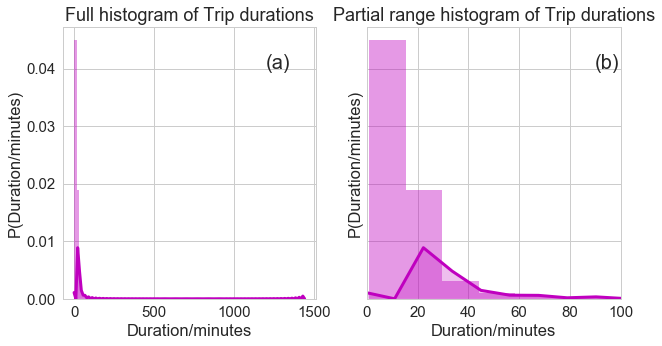

In [8]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

sns.distplot(trips2017['tripduration'], bins=100,hist=True, kde=True, color='m', kde_kws = {'shade': True, 'linewidth': 3}, ax=ax[0])
#plt.xlim(0, 2)
ax[0].set_title('Full histogram of Trip durations')
ax[0].set_xlabel('Duration/minutes')
ax[0].set_ylabel('P(Duration/minutes)')
ax[0].text(1200, 0.04,'(a)', fontsize=20) 

sns.distplot(trips2017['tripduration'], bins=100, hist=True, kde=True, color='m', kde_kws = {'shade': True, 'linewidth': 3}, ax=ax[1])
plt.xlim(0,100)
ax[1].set_title('Partial range histogram of Trip durations')
ax[1].set_xlabel('Duration/minutes')
ax[1].set_ylabel('P(Duration/minutes)')
ax[1].text(90, 0.04,'(b)', fontsize=20) 
fig.show()

Although the summary statistics above show that trip durations extend from a few seconds to up to 1433 minutes, trips longer than 200 minutes are infrequent as per figure (a) above. Note also that the largest reported trip duration of 1433 is slightly smaller than 1440 minutes whcich corresponds to a 24 hour bike rental.

Based on Figures (a) and (b) above, the distribution of trip duration appears to be a stretched exponential which is exponential at small trip durations but has a long tail corresponding to long trip durations.

Most trips appear to be short lasting for up to half an hour. Perhaps most people use Divvy's bikes for short distance commutes.

#### 2.2.4. How does customer gender affect trip duration?

To quantify this affect, lets start by changing 'gender' to a string type and counting the distinct values. Any missing values will be counted now.

In [9]:
trips2017['gender'] = trips2017['gender'].astype(str)
trips2017['gender'].value_counts()/len(trips2017)

Male      0.586456
nan       0.218549
Female    0.194995
Name: gender, dtype: float64

Almost 22.8% of the customers do not have a gender assigned. Lets rename nan values as 'Missing'.

In [10]:
# Replace nan with 'Missing'
trips2017['gender'].replace('nan', 'Missing',inplace=True)

Now get the fraction of trips ascribed to each gender type in the dataset

In [11]:
trips2017['gender'].value_counts()/len(trips2017)

Male       0.586456
Missing    0.218549
Female     0.194995
Name: gender, dtype: float64

Now we can look at the distribution of trip durations for each gender type in the dataset

<Figure size 864x720 with 0 Axes>

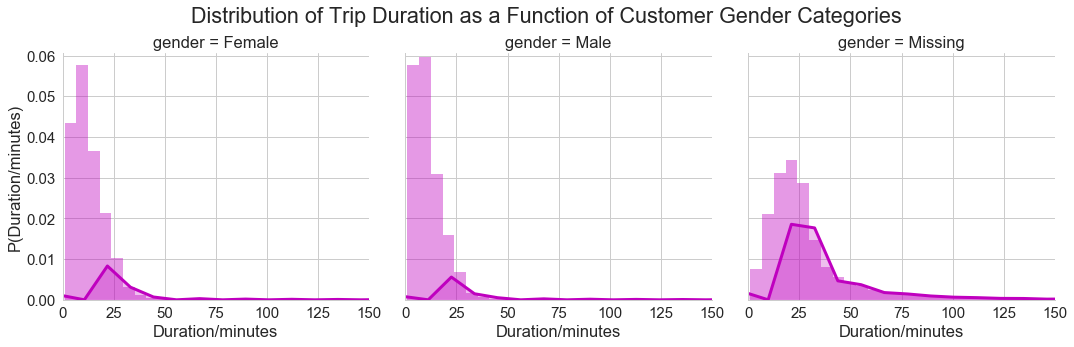

In [12]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12,10))
g = sns.FacetGrid(trips2017, col="gender", size=5, col_order=["Female", "Male", "Missing"], xlim=(0,150), sharex=True, sharey=True)
g.map(sns.distplot, "tripduration", hist=True, kde=True, bins=250, color="m", kde_kws = {'shade': True, 'linewidth': 3})
g.axes[0,0].set_xlabel('Duration/minutes')
g.axes[0,1].set_xlabel('Duration/minutes')
g.axes[0,2].set_xlabel('Duration/minutes')
g.axes[0,0].set_ylabel('P(Duration/minutes)')
g.fig.suptitle('Distribution of Trip Duration as a Function of Customer Gender Categories')
g.fig.subplots_adjust(top=.85)

There does not appear to be a significant difference in the trip duration for male and female customers, although perhaps male customers tend to have a slightly larger number of short trips with duration less than half an hour.

The distribution of trip durations for the Missing gender category is different from the Male and Female category. For this category, the number of very short trips (order of few minutes) is small and most trips have a longer duration. To understand the Missing gender category, other features will be analyzed below.

#### 2.2.5. How does customer type affect trip duration?

To qualify this effect, lets start by counting the different types of customers in the dataset

In [13]:
trips2017['usertype'].value_counts()

Subscriber    2992135
Customer       836872
Dependent           7
Name: usertype, dtype: int64

The README files indicate that there are two user types, Subscriber and Customer. However, the actual dataset has a third category called Dependent. Since the number of Dependent is so small, it is likely to be an error from the past which has been corrected recently. A possible scenario for its existence is that Subscribers may have been able to include their children as Dependent, but instead of being considered as Subscribers, they show up as Dependent. Note that Customers do not provide any information at the time of booking, so it is unlikely that Dependents belong to the Customer category. To check this, lets display the seven lines for Dependent

In [14]:
trips2017[ trips2017['usertype']=='Dependent']

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
361830,13070858,2017-01-22 08:14:54,2017-01-22 08:18:51,3190,3.950000,207,Emerald Ave & 28th St,206,Halsted St & Archer Ave,Dependent,Male,1979.0
235830,13231738,2017-02-18 07:47:21,2017-02-18 07:52:32,4576,5.183333,207,Emerald Ave & 28th St,206,Halsted St & Archer Ave,Dependent,Male,1979.0
166021,13313514,2017-02-27 07:02:01,2017-02-27 07:06:05,706,4.066667,207,Emerald Ave & 28th St,206,Halsted St & Archer Ave,Dependent,Male,1979.0
137180,13349140,2017-03-04 13:26:20,2017-03-04 13:43:25,2569,17.083333,207,Emerald Ave & 28th St,207,Emerald Ave & 28th St,Dependent,Male,1979.0
815870,15776123,2017-08-13 12:20:38,2017-08-13 12:35:31,3570,14.883333,327,Sheffield Ave & Webster Ave,177,Theater on the Lake,Dependent,Missing,1973.0
815467,15776556,2017-08-13 12:35:43,2017-08-13 13:04:52,3570,29.150000,177,Theater on the Lake,177,Theater on the Lake,Dependent,Missing,1973.0
814609,15777515,2017-08-13 13:05:00,2017-08-13 13:18:24,3570,13.400000,177,Theater on the Lake,327,Sheffield Ave & Webster Ave,Dependent,Missing,1973.0


Customers do not provide birthyear information, so this implies that Dependents are Subscribers. However, note that the gender of the Dependent is Missing. For simplification, lets include Dependents as Subscribers

In [15]:
trips2017.loc[ trips2017['usertype'] == 'Dependent', 'usertype'] = 'Subscriber'

Now lets see how the distribution of trip duration depends on the user type.

<Figure size 720x720 with 0 Axes>

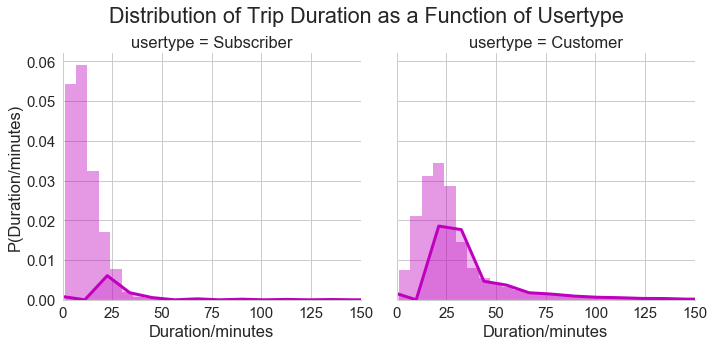

In [16]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(10,10))
g = sns.FacetGrid(trips2017, col="usertype", size=5, col_order=["Subscriber", "Customer"], xlim=(0,150), sharex=True, sharey=True)
g.map(sns.distplot, "tripduration", hist=True, kde=True, bins=250, color="m", kde_kws = {'shade': True, 'linewidth': 3})
g.axes[0,0].set_xlabel('Duration/minutes')
g.axes[0,1].set_xlabel('Duration/minutes')
g.axes[0,0].set_ylabel('P(Duration/minutes)')
g.fig.suptitle('Distribution of Trip Duration as a Function of Usertype')
g.fig.subplots_adjust(top=.85)

Bike riders who are Subscribers appear to make a lot more short duration rides that Customers. One the other hand, Customers tend to make longer duration rides and potentially travel longer distances.

#### 2.2.6. How does gender and usertype affect trip duration?

To understand the gender and usertype data, lets group all trips by gender and usertype

In [17]:
trips2017[['gender','usertype','trip_id']].groupby(['usertype','gender']).count()

trip_id
usertype   gender          
Customer   Female       107
           Male         747
           Missing   836018
Subscriber Female    746530
           Male     2244803
           Missing      809

The README files indicated that gender information is unavailable for usertype Customer, i.e their gender should have been Missing. Instead, it turns out that there are 747 male and 107 female Customer usertypes. 

The README file also indicates that the gender information is available for usertype Subscribers. Turns out that there are 802 Subscribers for whom gender information is missing. Note that the actual number of missing gender Subscribers includes the 7 Dependents whose gender was missing.

<Figure size 1080x720 with 0 Axes>

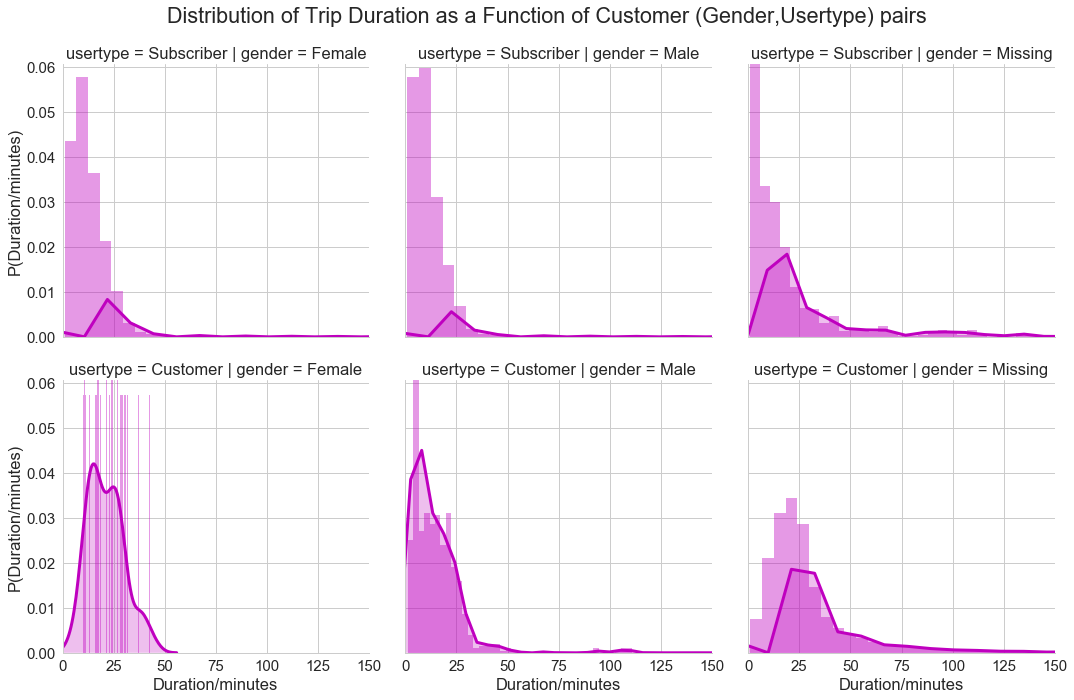

In [18]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(15,10))
g = sns.FacetGrid(trips2017, col="gender", row='usertype', size=5, col_order=["Female", "Male", "Missing"], row_order=['Subscriber', 'Customer'], xlim=(0,150), sharex=True, sharey=True)
g.map(sns.distplot, "tripduration", hist=True, kde=True, bins=250, color="m", kde_kws = {'shade': True, 'linewidth': 3})
g.axes[1,0].set_xlabel('Duration/minutes')
g.axes[1,1].set_xlabel('Duration/minutes')
g.axes[1,2].set_xlabel('Duration/minutes')
g.axes[0,0].set_ylabel('P(Duration/minutes)')
g.axes[1,0].set_ylabel('P(Duration/minutes)')
g.fig.suptitle('Distribution of Trip Duration as a Function of Customer (Gender,Usertype) pairs')
g.fig.subplots_adjust(top=.90)

As noted previously, the Missing gender bike riders were mostly of usertype Customer. These bike riders tend to make few very short rides and more rides typically 20 minutes or more. Based on very limited data on the gender of Customers, it would appear that Male customers rent bikes for a longer duration than Female Customers. The vertical lines in (Customer, Female) category are an artifact of constructing a distribution with only 107 data points.

On the other hand, for Subscribers, Male and Female subscribers tend to use bikes for almost similar durations, with Male Subscribers make more very short rides. Given the shape of the Missing gender Subscribers, it appears that their bike rental duration is similar to the usertype Customer with Missing gender, albeit with a larger number of short duration rentals. Perhaps the Subscribers with missing Gender information are customers who are usertype Customers that may have accidently signed up as Subscribers to get access to promotions. Although, additional information to make this determination is not available in the dataset.

#### 2.2.7. How does customer age affect trip duration?

Another feature available in the dataset is the birth year of the rider. Lets see what fraction of values are known. The rest are unknowns.

In [19]:
trips2017['birthyear'].count()/len(trips2017)

0.7814690674936159

In [20]:
trips2017['newbirthyear']=pd.to_datetime(trips2017['birthyear'], format='%Y.0')
trips2017['age']=(trips2017['start_time']-trips2017['newbirthyear']).dt.days
trips2017.drop(['newbirthyear'], axis=1, inplace=True)
trips2017['age'] = trips2017['age']/365.0
trips2017['age'].isnull().sum() 

836758

In [21]:
trips2017['age'].describe()

count    2.992256e+06
mean     3.597473e+01
std      1.088092e+01
min      7.315068e-01
25%      2.779726e+01
50%      3.268219e+01
75%      4.157534e+01
max      1.188192e+02
Name: age, dtype: float64

In [22]:
trips2017['age'].isnull().sum()

836758

The youngest bike rider is 0.73 years old while the oldest is 118.82 years old. Clearly, there is a large variation in age of the bike rider. Somewhere information about bikes with baby carriers is missing.

Lets find the age of bike riders and number of missing age values.

Since there are 836758 missing values for the age feature, perhaps it would be useful to split age into groups and treat each age group as a categorical variable. By doing so, missing values could also be included as a category. Lets split age into bins corresponding to 5 years. To account for missing values, lets replace the missing values with the age of 195.1. By doing so, another age category, distinct from others, is created and it will be assumed that this category represents missing values.

In [23]:
trips2017['age'] = trips2017['age'].fillna(195.1)
bins = list(range(0,205,5))
group_names = list(range(1,len(bins)))
trips2017['age_cats'] = pd.cut(trips2017['age'],bins,labels=group_names)
print(trips2017['age_cats'].unique())
#agecats.codes
#trips2017[['age','age_cats']]

[40, 7, 6, 10, 8, ..., 21, 23, 22, 3, 19]
Length: 24
Categories (24, int64): [1 < 3 < 4 < 5 ... 22 < 23 < 24 < 40]


Text(0,0.5,'Trip duration/minutes')

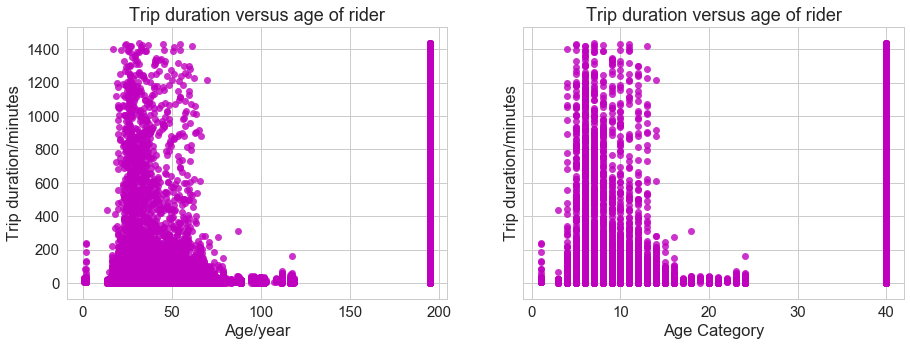

In [24]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)
sns.regplot(x="age", y="tripduration", color='m', scatter=True, fit_reg=False, data=trips2017, ax=ax[0])
sns.regplot(x="age_cats", y="tripduration", color='m', scatter=True, fit_reg=False, data=trips2017, ax=ax[1])
ax[0].set_title('Trip duration versus age of rider')
ax[0].set_xlabel('Age/year')
ax[0].set_ylabel('Trip duration/minutes')
ax[1].set_title('Trip duration versus age of rider')
ax[1].set_xlabel('Age Category')
ax[1].set_ylabel('Trip duration/minutes')

The overall scatter of points appears to resemble an asymmetric Gaussian distribution centered at around the age of 30 with a large age tail and a lower cutoff of about 12. At small values of age (around 1 year), there are a few points indicating that babies might be getting bike rides with their parents. No information content is lost by turning age into age categories. Of course, we now have a new age category that corresponds to missing values.

#### 2.2.8. How does the customers Age and Gender affect Trip duration?

<Figure size 1080x432 with 0 Axes>

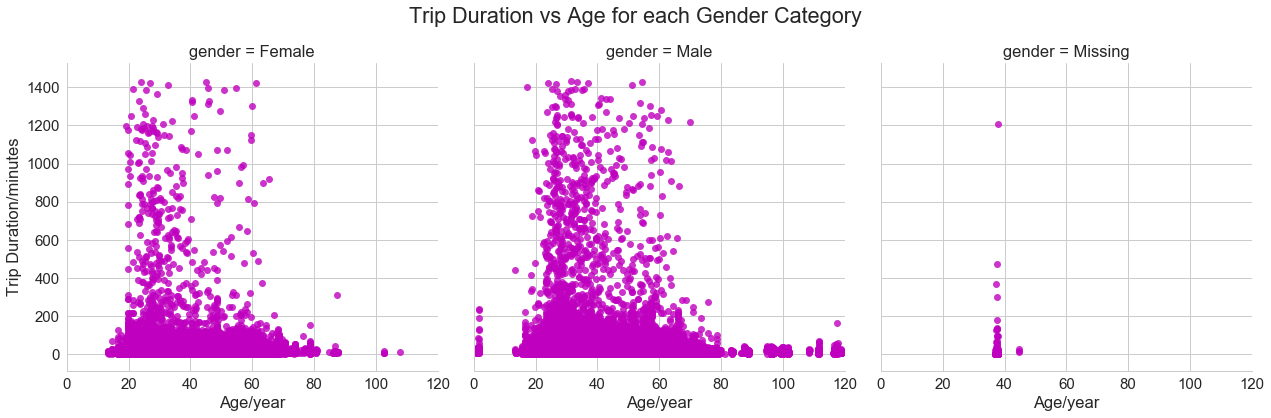

In [25]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(15,6))
g = sns.FacetGrid(trips2017, col="gender", size=6, col_order=["Female", "Male", "Missing"], xlim=(0,120), sharex=True, sharey=True)
g.map(sns.regplot, "age", "tripduration", color='m', scatter=True, fit_reg=False)
g.axes[0,0].set_xlabel('Age/year')
g.axes[0,1].set_xlabel('Age/year')
g.axes[0,2].set_xlabel('Age/year')
g.axes[0,0].set_ylabel('Trip Duration/minutes')
g.fig.suptitle('Trip Duration vs Age for each Gender Category')
g.fig.subplots_adjust(top=.85)

There is a non-monotonic variation of trip duration with age. The scatter plot for Female bike riders looks like it has a bimodal distribution with mean values of approximately 30 and 56, along with a smattering of points with long trip durations for ages 20 to 40. A similar shape can be discerned for Male riders as well, however it not as well defined. Furthermore, for Male riders the number of longer duration rentals as well as the age range associated with them is wider, an observation perhaps indicative of the larger number of Male bike riders with more age variation with respect to the number of Female riders.

The distribution of trip duration vs age for Male riders also shows the same group of points at the age of about 1 year. Apparently, babies are getting bike rides with their fathers and the trip duration is typically less than about 100 minutes but often reaching up to 4 hours.

For the Missing gender group, surprisingly most data points correspond to the rider age of about 38 and 43. Given the overall similarity of the distribution of points to that of the male and female riders, it is not possible to infer whether the missing gender rides are Male or Female.

#### 2.2.9. How does bike rental change over the course of the year 2017?

Although Gender, Age, and Usertype affect trip duration and consequently trip length, the time of the day, or week or week in a year may also affect the number of trips and trip duration. Lets take a look at the data

The datetime information will be used to extract additional information such as week of the year, day of the year, hour of the day, etc. Such information may have predictive value since in winter time or late in the night fewer customers are likely to ride bikes or their riding behavior may change. 

In [26]:
# From start_time
trips2017['start_hour'] = trips2017['start_time'].dt.hour # start hour
trips2017['start_day'] = trips2017['start_time'].dt.day # start day
trips2017['start_wday']    = trips2017['start_time'].dt.weekday_name # start day of week
trips2017['start_minute']  = trips2017['start_time'].dt.minute # start minute of day
trips2017["start_doy"]     = trips2017['start_time'].dt.dayofyear# start day of year
trips2017["start_woy"] = trips2017['start_time'].dt.week # start week of year
trips2017['start_date'] = trips2017['start_time'].dt.date

In [27]:
# From end_time
trips2017['end_hour'] = trips2017['end_time'].dt.hour # start hour
trips2017['end_day'] = trips2017['end_time'].dt.day # start day
trips2017['end_wday']    = trips2017['end_time'].dt.dayofweek # start day of week
trips2017['end_minute']  = trips2017['end_time'].dt.minute # start minute of day
trips2017["end_doy"]     = trips2017['end_time'].dt.dayofyear # start day of year
trips2017["end_woy"] = trips2017['end_time'].dt.week # start week of year

In [28]:
trips2017.head(5)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,...,start_minute,start_doy,start_woy,start_date,end_hour,end_day,end_wday,end_minute,end_doy,end_woy
431690,12979230,2017-01-01 00:00:36,2017-01-01 00:06:32,2511,5.933333,414,Canal St & Taylor St,191,Canal St & Monroe St (*),Customer,...,0,1,52,2017-01-01,0,1,6,6,1,52
431689,12979231,2017-01-01 00:02:54,2017-01-01 00:08:21,3660,5.450000,28,Larrabee St & Menomonee St,20,Sheffield Ave & Kingsbury St,Subscriber,...,2,1,52,2017-01-01,0,1,6,8,1,52
431688,12979232,2017-01-01 00:06:06,2017-01-01 00:18:31,4992,12.416667,620,Orleans St & Chestnut St (NEXT Apts),333,Ashland Ave & Blackhawk St,Subscriber,...,6,1,52,2017-01-01,0,1,6,18,1,52
431687,12979233,2017-01-01 00:07:28,2017-01-01 00:12:51,5637,5.383333,287,Franklin St & Monroe St,68,Clinton St & Tilden St,Subscriber,...,7,1,52,2017-01-01,0,1,6,12,1,52
431686,12979234,2017-01-01 00:07:57,2017-01-01 00:20:53,2209,12.933333,300,Broadway & Barry Ave,118,Sedgwick St & North Ave,Subscriber,...,7,1,52,2017-01-01,0,1,6,20,1,52


In [29]:
df_group_by_date = trips2017[['trip_id','start_date']].groupby('start_date').size().reset_index(name='counts')
df_group_by_date.head(5)

,start_date,counts
0,2017-01-01,1727
1,2017-01-02,1960
2,2017-01-03,4537
3,2017-01-04,3269
4,2017-01-05,2917


In [30]:
s = trips2017['usertype']=='Customer'
df_group_by_date_customer = trips2017.loc[s, ['trip_id','start_date']].groupby('start_date').size().reset_index(name='counts')

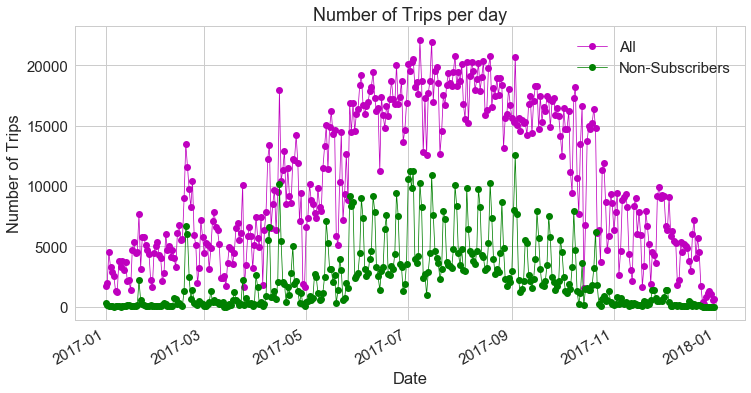

In [31]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 0.75})
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.plot_date(df_group_by_date['start_date'], df_group_by_date["counts"], color="m", label="All", linestyle="-")
ax.plot_date(df_group_by_date_customer['start_date'], df_group_by_date_customer["counts"], color="g", label="Non-Subscribers", linestyle="-")
plt.gcf().autofmt_xdate()

ax.set_title('Number of Trips per day')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Trips')
ax.legend()
plt.show()

Note that Chicago has cold weather at the beginning and end of the year. At these times, the number of trips per day is very small. The maximum number of trips is reached in July. Not only is this the warmest part of the season but there is a Fourth of July celebration which draws in a lot of people to downtown Chicago and due to street closings bikes are a convenient mode of travel. There are other dates on which the number of bike rides increases or decreases drastically. To figure out their cause one would have to incorporate weather as well as the free events calander for the city of Chicago.

Noe that the number of Customers increases dramatically over warmer parts of the year compared to the cold months where most Customers stop using bikes for commuting. Although the number of Subscribers decreases as well, it is much larger than the number of Customers.

#### 2.2.10. How does bike rental vary over the course of a week?

In [32]:
df_group_by_day = trips2017[['trip_id','start_wday']].groupby('start_wday').size().reset_index(name='All')
df_group_by_day_customer = trips2017.loc[s, ['trip_id','start_wday']].groupby('start_wday').size().reset_index(name='Customer')
df_group_by_day['Customer'] = df_group_by_day_customer['Customer']
df_group_by_day['Subscriber']=df_group_by_day['All']-df_group_by_day['Customer']
df_group_by_day

,start_wday,All,Customer,Subscriber
0,Friday,554657,96453,458204
1,Monday,578996,106774,472222
2,Saturday,530929,224611,306318
3,Sunday,492564,201484,291080
4,Thursday,550066,67910,482156
5,Tuesday,578893,77839,501054
6,Wednesday,542909,61801,481108


In [33]:
tmpdf = pd.melt(df_group_by_day, id_vars="start_wday", var_name="Type", value_name="Count")
tmpdf['start_wday'] = pd.Categorical(tmpdf['start_wday'], ["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"])
tmpdf.sort_values(['start_wday'], axis=0, inplace=True)

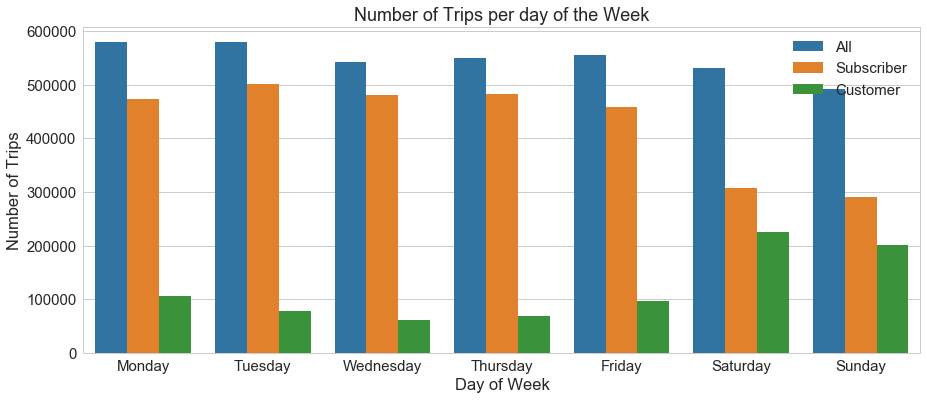

In [34]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
sns.barplot(x='start_wday', y='Count', hue='Type', data=tmpdf, ax=ax)
ax.set_title('Number of Trips per day of the Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of Trips')
ax.legend()

The weekend brings in more non-Subscribers to town and this is associated with a larger number of bike rides. During the week, the number of Subscribers does not change much and this is expected since they tend to rely on communting on weekdays.

#### 2.2.11. How does bike rental varies over the course of a day?

In [35]:
df_group_by_hour = trips2017[['trip_id','start_hour']].groupby('start_hour').size().reset_index(name='All')
df_group_by_hour_customer = trips2017.loc[s, ['trip_id','start_hour']].groupby('start_hour').size().reset_index(name='Customer')
df_group_by_hour['Customer'] = df_group_by_hour_customer['Customer']
df_group_by_hour['Subscriber']=df_group_by_hour['All']-df_group_by_hour['Customer']

In [36]:
tmpdf = pd.melt(df_group_by_hour, id_vars="start_hour", var_name="Type", value_name="Count")
#tmpdf['start_wday'] = pd.Categorical(tmpdf['start_wday'], ["Monday", "Tuesday", "Wednesday","Thursday","Friday","Saturday","Sunday"])
tmpdf.sort_values(['start_hour'], axis=0, inplace=True)

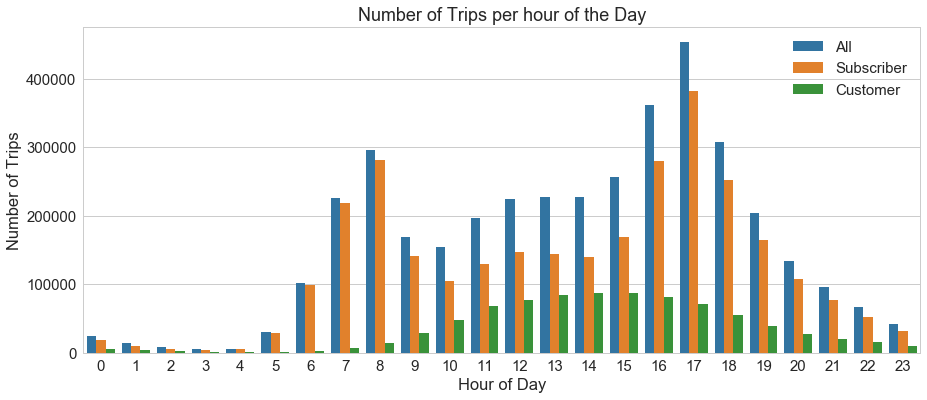

In [37]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
sns.barplot(x='start_hour', y='Count', hue='Type', data=tmpdf, ax=ax)
ax.set_title('Number of Trips per hour of the Day')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Trips')
ax.legend()

The number of trips per hour of the day shows a few clear cyclic trends. The number of non-subscriber trips increases after 7 am up to 3 pm and then starts decreasing through the evening. On the other hand, the number of Subscribers peaks at around 8 am and 5 pm, clearly associated with office hours.

### 2.3. Stations data

For each bike ride, Divvy provides a trip identifier (trip_id), the date+time at which the bike rental started (start_time), the date+time at which the bike was returned (end_time), the bike identifier (bikeid), the duration of the trip (in seconds), the name and id of the station from which the bike was rented, and the name as well as id of the station at which the bike was returned. 

Based on the available data, we have an estimate of trip duration and the names of the start and end points for the ride. Since the objective is to model whether a trip will cover 2km or less, we need distance information. To figure out the distance between the start and end points, we need additional information about the station, i.e, the lattitude and longitude for the station location. Fortunately, this information is provided in the Stations data file and will be considered here.

#### 2.3.1. Loading the Station data

Again using the bike station information for the year 2017, lets look at the location of the stations on a map of Chicago to place this data in perspective.

In [38]:
stations2017 = pd.read_csv(filelist1[len(filelist1)-4])
stations2017['online_date']=pd.to_datetime(stations2017['online_date'])
stations2017.drop(['Unnamed: 7'], axis=1, inplace=True)
stations2017.head(5)

,id,name,city,latitude,longitude,dpcapacity,online_date
0,2,Buckingham Fountain,Chicago,41.876393,-87.620328,27,2013-06-10 10:43:00
1,3,Shedd Aquarium,Chicago,41.867226,-87.615355,55,2013-06-10 10:44:00
2,4,Burnham Harbor,Chicago,41.856268,-87.613348,23,2013-06-10 10:46:00
3,5,State St & Harrison St,Chicago,41.874053,-87.627716,23,2013-06-10 10:46:00
4,6,Dusable Harbor,Chicago,41.885041,-87.612794,39,2013-06-10 11:18:00


So the Stations data provides information on the bike station id(id), name of the bike station, the city (potential suburban locations), the latitude and longitude for each bike station, the number of bike racks at each station, and the date when the bike station started being available for service.

#### 2.3.2. Where are the bike stations located in Chicago?

Lets display the location of the bike stations.

In [39]:
# Make sure that latitude and longitude data is of type float
stations2017['latitude'] = stations2017['latitude'].astype(np.float32)
stations2017['longitude'] = stations2017['longitude'].astype(np.float32)

# Identify a central location
(midlat, midlon) = (stations2017['latitude'].median(), stations2017['longitude'].median())

# Initialize the map
map1 = folium.Map(location=[midlat, midlon], zoom_start=11)

# Add a circle marker for every bike stations location
for idx, data in stations2017.iterrows():
    folium.CircleMarker([data['latitude'], data['longitude']], radius=1, popup=data['name'],fill_color="#3db7e4").add_to(map1)

# Pass latitude and longitude data as a list of lists List
heat_data = [[row['latitude'],row['longitude']] for index, row in stations2017.iterrows()]

# plot heatmap
map1.add_child(plugins.HeatMap(heat_data, radius=14))
    
map1

Looks like Divvy has pretty good coverage for the city of Chicago. There are some parts of Chicago with a higher density of bike stations, such as near the Navy Pier which is part of downtown Chicago.

#### 2.3.3. What is the distance travelled during each bike rental?

Unlike the tripduration which is a continuous variable, the distance travelled by a rented bike between two stations can be accurately measured with a trip odometer or some similar device. The dataset does not include such a distance. Instead, after merging the datasets, we have access to the geographic coordinates for the station where the bike was rented and the station where the bike was returned. A distance calculated based on these coordinates just measures the displacement of the bike over the duration of the trip, not the total distance travelled by the bike. However, for the sake of modeling, the distance travelled by the bike will be approximated with the displacement. <B>Now the task turns into building a model for whether a bike rental will take the bike to a station at a distance less than 2 km from the starting bike station or not.</B>

Next, lets figure out the distance between the origin and destination bike stations. Such a distance could be calculated in several ways, e.g., the Euclidean distance or the Manhattan distance. Given the North-South block-like shape of streets in Chicago, the Manhattan distance is selected as the proxy for inter-station distance. Now lets join the stations2017 data with the trips data for 2017 before we can calcualte any distances.

In [40]:
list1 = ['id','latitude','longitude']
merged_df = pd.merge(trips2017, stations2017[list1], left_on='from_station_id', right_on='id', how='left')
merged_df.rename(columns={"latitude":"from_latitude", "longitude":"from_longitude"}, inplace=True)
merged_df = pd.merge(merged_df, stations2017[list1], left_on='to_station_id', right_on='id', how='left')
merged_df.rename(columns={"latitude":"to_latitude", "longitude":"to_longitude"}, inplace=True)
merged_df.drop(['id_x','id_y'], axis=1, inplace=True)
merged_df.head(5)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,...,end_hour,end_day,end_wday,end_minute,end_doy,end_woy,from_latitude,from_longitude,to_latitude,to_longitude
0,12979230,2017-01-01 00:00:36,2017-01-01 00:06:32,2511,5.933333,414,Canal St & Taylor St,191,Canal St & Monroe St (*),Customer,...,0,1,6,6,1,52,41.870258,-87.639473,41.880882,-87.639526
1,12979231,2017-01-01 00:02:54,2017-01-01 00:08:21,3660,5.450000,28,Larrabee St & Menomonee St,20,Sheffield Ave & Kingsbury St,Subscriber,...,0,1,6,8,1,52,41.914680,-87.643318,41.910522,-87.653107
2,12979232,2017-01-01 00:06:06,2017-01-01 00:18:31,4992,12.416667,620,Orleans St & Chestnut St (NEXT Apts),333,Ashland Ave & Blackhawk St,Subscriber,...,0,1,6,18,1,52,41.898205,-87.637535,41.907066,-87.667252
3,12979233,2017-01-01 00:07:28,2017-01-01 00:12:51,5637,5.383333,287,Franklin St & Monroe St,68,Clinton St & Tilden St,Subscriber,...,0,1,6,12,1,52,41.880318,-87.635185,41.875885,-87.640793
4,12979234,2017-01-01 00:07:57,2017-01-01 00:20:53,2209,12.933333,300,Broadway & Barry Ave,118,Sedgwick St & North Ave,Subscriber,...,0,1,6,20,1,52,41.937725,-87.644096,41.911385,-87.638680


In [41]:
# Calculate the Manhattan distance on a spherical surface based on the approach 
# on https://stackoverflow.com/questions/32923363/manhattan-distance-for-two-geolocations
def calculate_dist(row):
    # dlat
    dlat = 0.5*np.abs(math.radians(row['from_latitude']-row['to_latitude']))
    a1 = np.square(np.sin(dlat))
    t1 = np.sqrt(a1)
    t2 = np.sqrt(1.0-a1)
    c1 = 2.0*np.arctan2(t1,t2) # Haversine formula for dlat
    dlatval = 6371.0*c1
    
    # dlong
    dlong = 0.5*np.abs(math.radians(row['from_longitude']-row['from_longitude']))
    a2 = np.square(np.sin(dlong))
    t1 = np.sqrt(a2)
    t2 = np.sqrt(1.0-a2)
    c2 = 2.0*np.arctan2(t1,t2) # Haversine formula for dlong
    dlongval = 6371.0*c2
    
    return np.abs(dlatval)+np.abs(dlongval)

In [42]:
merged_df['dist'] = merged_df.apply(calculate_dist, axis=1)

In [43]:
merged_df['dist'].describe()

count    3.829014e+06
mean     1.457618e+00
std      1.496289e+00
min      0.000000e+00
25%      4.038146e-01
50%      1.002750e+00
75%      2.016528e+00
max      2.566301e+01
Name: dist, dtype: float64

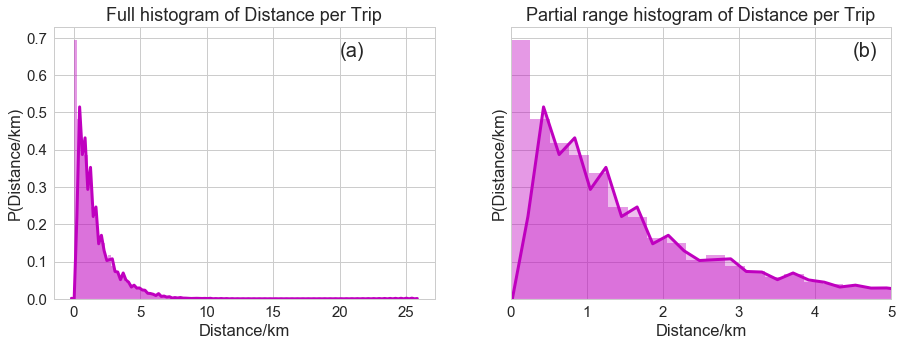

In [44]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(15, 5))

sns.distplot(merged_df['dist'], bins=100,hist=True, kde=True, color='m', kde_kws = {'shade': True, 'linewidth': 3}, ax=ax[0])
ax[0].set_title('Full histogram of Distance per Trip')
ax[0].set_xlabel('Distance/km')
ax[0].set_ylabel('P(Distance/km)')
ax[0].text(20, 0.65,'(a)', fontsize=20) 

sns.distplot(merged_df['dist'], bins=100, hist=True, kde=True, color='m', kde_kws = {'shade': True, 'linewidth': 3}, ax=ax[1])
plt.xlim(0,5)
ax[1].set_title('Partial range histogram of Distance per Trip')
ax[1].set_xlabel('Distance/km')
ax[1].set_ylabel('P(Distance/km)')
ax[1].text(4.5, 0.65,'(b)', fontsize=20) 
fig.show()

The peak at zero distance indicates that a lot of rides start and end at the same bike station. Other than these round trip bike rides, the most frequent distance destination bike station is about 0.4 km away from the bikes origin station.

#### 2.3.4. Is there any correlation between gender and distance?

Given the similarity in the distribution of trip durations for Male and Female genders, and the difference in their distribution with respect to the Missing gender group, a natural question is, do these differences show up in the trip distance as well ? To answer this lets plot the distribution of distance for each gender.

<Figure size 864x720 with 0 Axes>

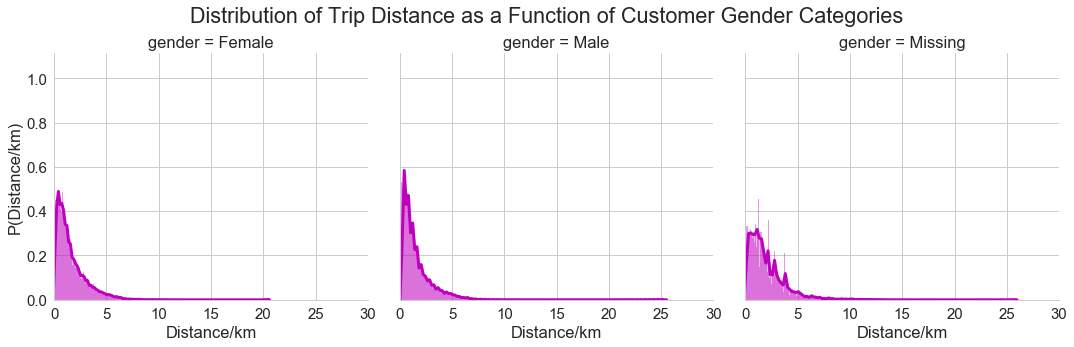

In [45]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12,10))
g = sns.FacetGrid(merged_df, col="gender", size=5, col_order=["Female", "Male", "Missing"], xlim=(0,30), sharex=True, sharey=True)
g.map(sns.distplot, "dist", hist=True, kde=True, bins=250, color="m", kde_kws = {'shade': True, 'linewidth': 3})
g.axes[0,0].set_xlabel('Distance/km')
g.axes[0,1].set_xlabel('Distance/km')
g.axes[0,2].set_xlabel('Distance/km')
g.axes[0,0].set_ylabel('P(Distance/km)')
g.fig.suptitle('Distribution of Trip Distance as a Function of Customer Gender Categories')
g.fig.subplots_adjust(top=.85)

The overall distribution of distances per ride are similar in form for the male and female genders, the only difference being slightly more short distance trips. In contrast to this, the Missing gender category trips distribution has s slightly broader short distance peak.

#### 2.3.5 How does the travel distance depend on Usertype?

In Section 2.2.5 it was observed that the distribution of trip durations varies with Usertype. Here, the effect of usertype on trip distance will be considered.

<Figure size 720x720 with 0 Axes>

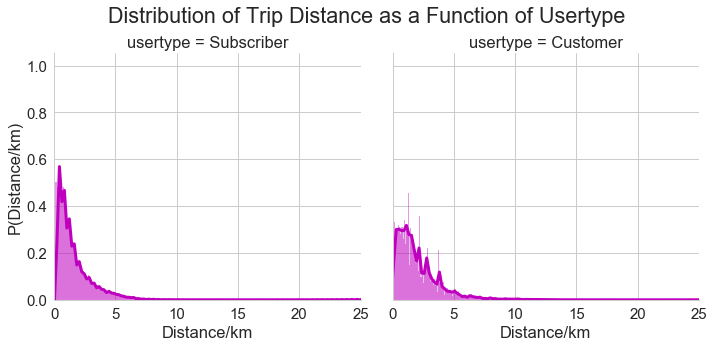

In [46]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(10,10))
g = sns.FacetGrid(merged_df, col="usertype", size=5, col_order=["Subscriber", "Customer"], xlim=(0,25), sharex=True, sharey=True)
g.map(sns.distplot, "dist", hist=True, kde=True, bins=250, color="m", kde_kws = {'shade': True, 'linewidth': 3})
g.axes[0,0].set_xlabel('Distance/km')
g.axes[0,1].set_xlabel('Distance/km')
g.axes[0,0].set_ylabel('P(Distance/km)')
g.fig.suptitle('Distribution of Trip Distance as a Function of Usertype')
g.fig.subplots_adjust(top=.85)

Just as Subscribers tend to make short duration trips, they also prefer making short distance trips. Usertype Customer tend to make longer duration trips and travel longer distances. So, trip distance and trip duration appear to be correlated for Subscribers and Customers.

#### 2.3.6. Are there any correlation between Distance and Trip Duration?

Here we check if there is any correlation between the distance from the starting bike station to the terminal bike station with the time duration of the trip.

Text(0,0.5,'Trip duration/minute')

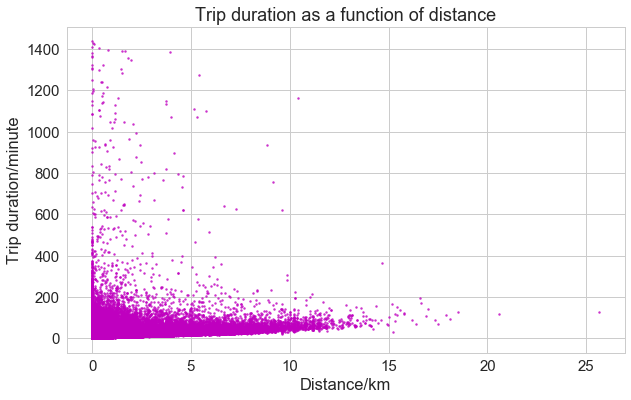

In [47]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.regplot(x="dist", y="tripduration", color='m', scatter=True, fit_reg=False, data=merged_df.sample(frac=0.1, replace=False, random_state=42), scatter_kws={'s':6}, ax=ax)
ax.set_title('Trip duration as a function of distance')
ax.set_xlabel('Distance/km')
ax.set_ylabel('Trip duration/minute')

The overall distribution of points suggests the presence of two patterns. First, it appears that long distance trips are associated with longer trip duration. Second, trips that end with the return of bikes close to the starting bike station have a large extent of variation in trip duration. These two trends are consistent with Subscriber travel distances being diverse when bikes are turned close to the staring point and with Customers travelling longer distances and times before returning their bikes.

#### 2.3.7. How does age affect the Distance travelled ?

Here the dependence of travel Distance on the travellers age is considered. Since age was partitioned into groups, and therefore age categories, the trip distance as a function of age category is also presented below.

Text(0,0.5,'Trip distance/km')

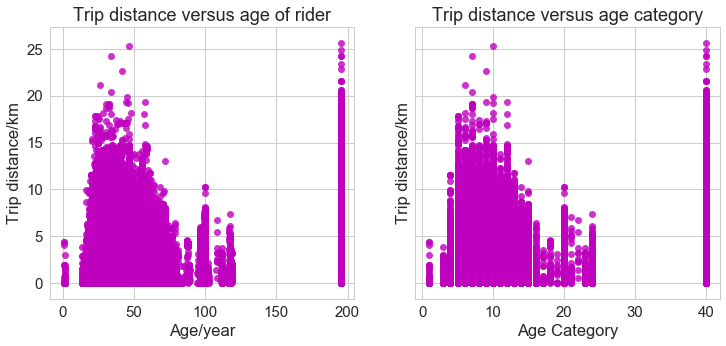

In [48]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)
sns.regplot(x="age", y="dist", color='m', scatter=True, fit_reg=False, data=merged_df, ax=ax[0])
sns.regplot(x="age_cats", y="dist", color='m', scatter=True, fit_reg=False, data=merged_df, ax=ax[1])
ax[0].set_title('Trip distance versus age of rider')
ax[1].set_title('Trip distance versus age category')
ax[0].set_xlabel('Age/year')
ax[1].set_xlabel('Age Category')
ax[0].set_ylabel('Trip distance/km')
ax[1].set_ylabel('Trip distance/km')

Here certain similarities with Trip duration are visible. The behavior of different age ranges is similar. The youngest bike riders (about 1 year or less) tend to travel short distances and have short trips. As age of the rider increases from about 13 to 80, there is an approximately Cauchy distribution-like variation of trip distance as well as trip duration with age. Beyons about 80 years, there are 5 groups of older bike riders who tend to make trips of 10 km or less. Given the presence of peaks in the male bike riders with the same age range, it is likely that there is a group of old male bike riders who make intermediate range bike rides.

The Trip distance shows the same variation with respect to age categories.

#### 2.3.8. Does Bike identity contain any information on distance travelled ?

Lets first take a look at how many unique bikes are deployed by Divvy.

In [49]:
#merged_df['bikeid'] = merged_df['bikeid'].astype('category')
merged_df['bikeid'].nunique()

6243

Next, it should be noted that unless certain bikes are always brought back to bike stations from which longer rides originate, there should be no correlation between bike id and trip duration or distance. Lets take a look at each bikes trip distance and duration.

Text(0,0.5,'Trip duration/km')

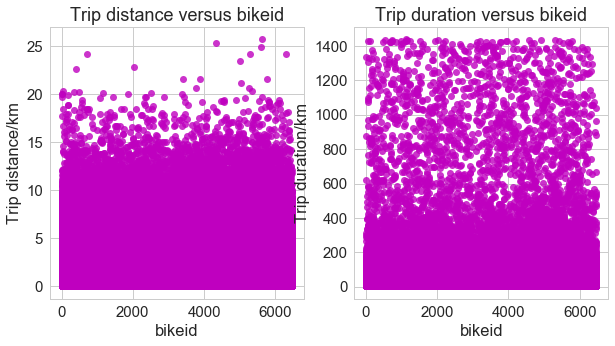

In [50]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=False)
sns.regplot(x="bikeid", y="dist", color='m', scatter=True, fit_reg=False, data=merged_df, ax=ax[0])
sns.regplot(x="bikeid", y="tripduration", color='m', scatter=True, fit_reg=False, data=merged_df, ax=ax[1])
ax[0].set_title('Trip distance versus bikeid')
ax[1].set_title('Trip duration versus bikeid')
ax[0].set_xlabel('bikeid')
ax[1].set_xlabel('bikeid')
ax[0].set_ylabel('Trip distance/km')
ax[1].set_ylabel('Trip duration/km')

There does not appear to be a correlation between bikeid and trip distance or trip duration. Lets further quantify it by calculating the correlation between the bikeid column and the trip distance column.

In [51]:
print(merged_df['bikeid'].corr(merged_df['dist']))
print(merged_df['bikeid'].corr(merged_df['tripduration']))

0.014428615969512922
-0.008204824603297951


Bikeid is therefore uncorrelated with trip distance or trip duration.

#### 2.3.9. Which are the most popular bike ride origin stations ?

So far the geographical factors affecting the nature of a bike ride have not been considered. Which are the most popular bike ride stations for starting a bike rental ? Do age, customer type or gender determine which bike locations will be preferred?  Here, these queries will be addressed.

In [52]:
#score_start_station = merged_df[['trip_id','from_station_name']].groupby('from_station_name').size().reset_index(name='Count')
score_start_station = merged_df.groupby('from_station_name').size().reset_index(name='Count')
score_start_station.sort_values('Count',inplace=True, ascending=False)
score_start_station[['from_station_name','Count']].head(5)

,from_station_name,Count
524,Streeter Dr & Grand Ave,97571
310,Lake Shore Dr & Monroe St,53400
80,Canal St & Adams St,50911
143,Clinton St & Washington Blvd,49832
526,Theater on the Lake,47908


Streeter Dr & Grand Ave is the overwhelmingly favorite starting point for bike rides. As it turns out, this intersection is right by the Navy Pier in Chicago which is a top tourist destination ! Lake Shore Dr and Monroe St is close the Chicago Yatch Club area  by the lake and is a popular destination as well. Canal St. and Adams St. is right in the middle of an area of Chicago with a high density of restaurants and businesses. So it makes sense for these stations to be the top origin points for bike rides.

Next, group starting station and gender to find out how station and gender are correlated

In [53]:
count_station_gender = merged_df.groupby(['from_station_name','gender']).size().reset_index(name='Count')
count_station_gender.sort_values('Count',inplace=True, ascending=False)
count_station_gender[['from_station_name','gender','Count']].head(10)

,from_station_name,gender,Count
1564,Streeter Dr & Grand Ave,Missing,77350
427,Clinton St & Washington Blvd,Male,42622
928,Lake Shore Dr & Monroe St,Missing,42148
238,Canal St & Adams St,Male,41778
415,Clinton St & Madison St,Male,35431
931,Lake Shore Dr & North Blvd,Missing,28083
247,Canal St & Madison St,Male,27709
681,Franklin St & Monroe St,Male,27409
1570,Theater on the Lake,Missing,26383
879,Kingsbury St & Kinzie St,Male,26265


It is surprising that Missing gender contributes to the most popular starting bike stations. Of course, given that Missing gender is typical of usertype Customer and the popular destinations are in prime tourist locations, the presence of the Missing gendertype should be expected. In this case, it is quite possible that both Male and Female bike riders are renting the bikes.

Finally, group the starting station and Usertype and find the most popular starting station

In [54]:
count_station_usertype = merged_df.groupby(['from_station_name','usertype']).size().reset_index(name='Count')
count_station_usertype.sort_values('Count',inplace=True, ascending=False)
count_station_usertype[['from_station_name','usertype','Count']].head(10)

,from_station_name,usertype,Count
1047,Streeter Dr & Grand Ave,Customer,77370
161,Canal St & Adams St,Subscriber,48928
287,Clinton St & Washington Blvd,Subscriber,48142
279,Clinton St & Madison St,Subscriber,42512
620,Lake Shore Dr & Monroe St,Customer,42153
589,Kingsbury St & Kinzie St,Subscriber,32924
457,Franklin St & Monroe St,Subscriber,32261
167,Canal St & Madison St,Subscriber,31921
291,Columbus Dr & Randolph St,Subscriber,29083
319,Daley Center Plaza,Subscriber,28599


Most of the popular bike ride origin stations are in dense office areas where it is likely that commuters will rent bikes regularly as Subscribers. The top station names with large number of usertype Customer are in the popular tourist destinations. So, there is a string correlation between the origin points purpose (tourist versus work) and prominence of usertype (Customer versus Subscriber)

#### 2.3.10. Which are the most popular bike destinations?

The same questions that were asked for the bike ride origin station can be asked about the bike destination as well.

In [55]:
score_start_station = merged_df[['trip_id','to_station_name']].groupby('to_station_name').size().reset_index(name='Count')
score_start_station.sort_values('Count',inplace=True, ascending=False)
score_start_station.head(5)

,to_station_name,Count
524,Streeter Dr & Grand Ave,106023
311,Lake Shore Dr & North Blvd,53091
80,Canal St & Adams St,52608
526,Theater on the Lake,50781
139,Clinton St & Madison St,50298


Just as for the bike ride origin stations, the most popular destination station for bike rides are also associated with tourist activities or office areas in downtown Chicago. Given that 77370 rides originate at Streeter/Grand and 106023 rides end at Streeter/Grand, it would appear that bike riders are taking alternative transportation or walk from Streeter/Grand.

#### 2.3.11. Which are the most popular origin-destination pairs ?

First we start with finding the origin-destination station pairs with the most trips between them

In [56]:
station_pair1 = merged_df.groupby(['from_station_name','to_station_name'])['trip_id'].size().reset_index().sort_values(by=['trip_id'], ascending=False)
station_pair1.rename({'trip_id':'trip_count'}).head(10)

,from_station_name,to_station_name,trip_id
50585,Lake Shore Dr & Monroe St,Streeter Dr & Grand Ave,12171
87780,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,10042
87781,Streeter Dr & Grand Ave,Theater on the Lake,8180
87634,Streeter Dr & Grand Ave,Lake Shore Dr & North Blvd,7993
50930,Lake Shore Dr & North Blvd,Streeter Dr & Grand Ave,7226
87633,Streeter Dr & Grand Ave,Lake Shore Dr & Monroe St,7192
88296,Theater on the Lake,Streeter Dr & Grand Ave,7049
50453,Lake Shore Dr & Monroe St,Lake Shore Dr & Monroe St,5447
87680,Streeter Dr & Grand Ave,Michigan Ave & Oak St,4760
87685,Streeter Dr & Grand Ave,Millennium Park,4262


Note that these pairs of stations are popular tourist destinations and they account for the most popular bike station pairs.

#### 2.3.12. Are there any group trips ?

It may be possible that some groups of people may travel from the same origin station, to the same destination station, and take about the same time. Lets see if this can discerned based on the data.

In [57]:
group_travel = merged_df.groupby(['from_station_name','to_station_name','start_date','start_hour','start_minute','end_hour','end_minute']).size().reset_index(name='group_count')
groups_df = group_travel[ group_travel['group_count']>1 ]
groups_df.head(5)

,from_station_name,to_station_name,start_date,start_hour,start_minute,end_hour,end_minute,group_count
49,2112 W Peterson Ave,Broadway & Ridge Ave,2017-07-16,11,7,11,20,2
173,2112 W Peterson Ave,Clark St & Bryn Mawr Ave,2017-06-19,16,0,16,14,2
281,2112 W Peterson Ave,Lincoln Ave & Leavitt St,2017-06-22,18,10,18,25,2
289,2112 W Peterson Ave,Maplewood Ave & Peterson Ave,2017-07-19,21,8,21,19,2
292,2112 W Peterson Ave,Maplewood Ave & Peterson Ave,2017-12-16,16,46,17,5,2


Lets find out the number of people who travel in groups and the percentage of all trips made by groups

In [58]:
print(len(groups_df), len(groups_df)/len(trips2017))

210310 0.05492536720941736


So there are 210310 trips with identical values of the combination of to_station, from_station, start_date, start_hour, start_minute, end_hour, end_minute. Although this is a conservative estimate, it does indicate that about 5.5% of all trips are made by a group of bike riders. If groups travel together, perhaps this information will be relevant to figuring out distances. 

Lets construct a new feature 'in_group' to indicate whether a trip_id in merged_df is present in groups_df

In [59]:
# Create an indicator that the row has features that are found in groups
groups_df['in_group']=1

# Join merged_df with groups_df
joined_df = pd.merge(merged_df, groups_df, on = ['from_station_name', 'to_station_name', 'start_date', 'start_hour', 'start_minute', 'end_hour', 'end_minute'], how='left')
joined_df.loc[ joined_df['in_group']!=1, 'in_group']=0
joined_df['group_count'] = joined_df['group_count'].fillna(1)
joined_df[ joined_df['in_group']!=1 ].head(5)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,...,end_minute,end_doy,end_woy,from_latitude,from_longitude,to_latitude,to_longitude,dist,group_count,in_group
0,12979230,2017-01-01 00:00:36,2017-01-01 00:06:32,2511,5.933333,414,Canal St & Taylor St,191,Canal St & Monroe St (*),Customer,...,6,1,52,41.870258,-87.639473,41.880882,-87.639526,1.181327,1.0,0.0
1,12979231,2017-01-01 00:02:54,2017-01-01 00:08:21,3660,5.450000,28,Larrabee St & Menomonee St,20,Sheffield Ave & Kingsbury St,Subscriber,...,8,1,52,41.914680,-87.643318,41.910522,-87.653107,0.462351,1.0,0.0
2,12979232,2017-01-01 00:06:06,2017-01-01 00:18:31,4992,12.416667,620,Orleans St & Chestnut St (NEXT Apts),333,Ashland Ave & Blackhawk St,Subscriber,...,18,1,52,41.898205,-87.637535,41.907066,-87.667252,0.985358,1.0,0.0
3,12979233,2017-01-01 00:07:28,2017-01-01 00:12:51,5637,5.383333,287,Franklin St & Monroe St,68,Clinton St & Tilden St,Subscriber,...,12,1,52,41.880318,-87.635185,41.875885,-87.640793,0.492891,1.0,0.0
4,12979234,2017-01-01 00:07:57,2017-01-01 00:20:53,2209,12.933333,300,Broadway & Barry Ave,118,Sedgwick St & North Ave,Subscriber,...,20,1,52,41.937725,-87.644096,41.911385,-87.638680,2.928928,1.0,0.0


In [60]:
joined_df['group_count']=joined_df['group_count'].astype(np.int32)
joined_df['group_count'].unique()

array([ 1,  2,  3,  4,  6,  5,  7, 11,  8], dtype=int64)

Now lets look at the distribution of trip counts as a function of number of people in the group and gender.

Text(0,0.5,'Trip count')

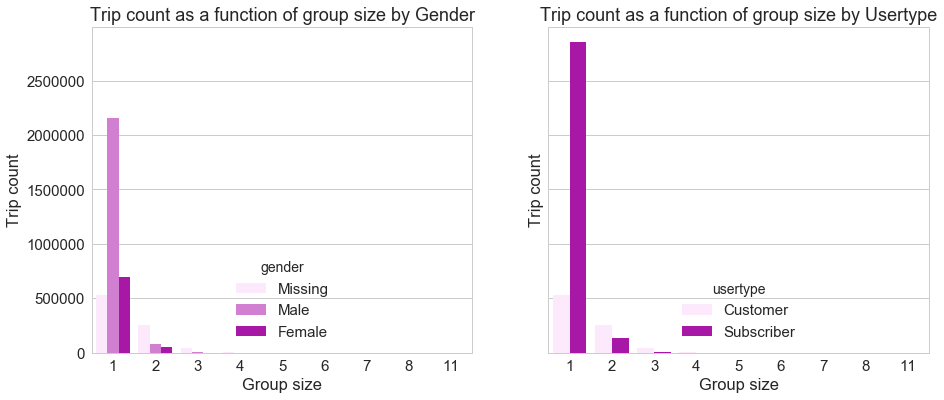

In [61]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)
sns.countplot(x="group_count", hue="gender", data=joined_df, color='m', ax=ax[0])
sns.countplot(x="group_count", hue="usertype", data=joined_df, color='m', ax=ax[1])
#sns.factorplot(x="group_count", hue="gender", col="usertype", data=joined_df, kind="count", color="m", ax=ax)
ax[0].set_title('Trip count as a function of group size by Gender')
ax[0].set_xlabel('Group size')
ax[0].set_ylabel('Trip count')
ax[1].set_title('Trip count as a function of group size by Usertype')
ax[1].set_xlabel('Group size')
ax[1].set_ylabel('Trip count')

The overall distribution appears to be an exponential decrease in trip counts as a function of group size. Individuals are the largest group of bike riders with male riders being about 3 times more common than female riders and missing gender riders being less common. As the group size increases to 2, the number of missing gender riders far exceeds the known gender riders. Given that missing gender riders are probably of usertype Customer who are potentially tourists that travel in groups, it makes sense that 2 bike riders would travel together. For group size of 3, the number of Missing gender riders is smaller that for group size 2 with more missing gender rider than female riders. The number of male riders is even smaller Larger group sizes are rather rate and are not even visible on the plot above.

To see if the inferences about usertype is reasonable, the trip counts are also plotted as a function of group size for Customer and Subscribers. Individual Subscribers are the largest group and about 5.6 times larger than individual Customers. For larger group sizes, the number of Customers exceeds the number of Subscribers. Given that larger Customers make longer trips than Subscribers, it is likely that the trip distance may also depend on the group size for different usertypes. Group size may then have predictive values for modeling trip distance

## 3. Constructing the class variable

Since we have to predict whether the trip distance is 2 km and less or not, we have to define a new feature (class) whose value is 1 if dist<2 and 0 otherwise. Lets construct this new feature and look at the class value distribution.

In [62]:
joined_df['class']=0
joined_df.loc[joined_df['dist']<=2.0,'class'] = 1

In [63]:
joined_df['class'].value_counts()/len(joined_df)

1    0.74753
0    0.25247
Name: class, dtype: float64

The final dataset has about 75% data from class 1 (i.e., trip distance of 2km or less) and about 25% from Class 2. It is fairly balanced and no special handling of class imbalance is required.

Having converted the trip distance into two classes, we can now delete the trip distance from the dataframe.

In [64]:
joined_df.drop( ['dist'], axis=1, inplace=True)

## 4. Feature pruning, checking data integrity, and saving final dataset

Now that we have a set of features, it is important to make sure we really need them for modeling, make sure there are no missing values, re-number categorical features so they can be used with embeddings, and finally save the dataset

### 4.1. Feature Pruning

Lets start by listing features that are available.

In [65]:
print(list(joined_df))

['trip_id', 'start_time', 'end_time', 'bikeid', 'tripduration', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'usertype', 'gender', 'birthyear', 'age', 'age_cats', 'start_hour', 'start_day', 'start_wday', 'start_minute', 'start_doy', 'start_woy', 'start_date', 'end_hour', 'end_day', 'end_wday', 'end_minute', 'end_doy', 'end_woy', 'from_latitude', 'from_longitude', 'to_latitude', 'to_longitude', 'group_count', 'in_group', 'class']


Columns which do not have predictive value are  'trip_id','start_time','end_time','bikeid','from_station_name','to_station_name','birthyear','start_date','Count'

Note that start_time and end_time have been broken down into start_hour, day, wday, minute, doy, woy, so we can delete them.

Note also that from_station_name and to_station_name can be deleted if we retain the from_station_id and to_station_id.

Birthyear is not useful since we have already converted it to age.

bikeid is uncorrelated with trip duration or trip dist and can be dropped as well.

As age contains missing values, it is preferable to use the age_cats categorical variable.

Since group_count is 1 or more, perhaps it is not necessary to keep in_group.

Lets drop all columns that are not useful

In [66]:
joined_df.drop(['trip_id','start_time','end_time','bikeid','from_station_name','to_station_name','birthyear','age','in_group','start_date'], axis=1, inplace=True)

### 4.2. Check if there are missing values

Now lets check whether any null values are present in the data.

In [67]:
joined_df.isnull().values.any()

False

The data appears to be free of missing values and is almost ready for model training and optimization.

### 4.3. Collect variables by type

Since we have variables of different types (categorical, and numerical), lets reorder data so each data type appears consecutively in the dataframe. We have the following columns

In [68]:
print(list(joined_df))

['tripduration', 'from_station_id', 'to_station_id', 'usertype', 'gender', 'age_cats', 'start_hour', 'start_day', 'start_wday', 'start_minute', 'start_doy', 'start_woy', 'end_hour', 'end_day', 'end_wday', 'end_minute', 'end_doy', 'end_woy', 'from_latitude', 'from_longitude', 'to_latitude', 'to_longitude', 'group_count', 'class']


Of these, tripduration, from_latitude, from_longitude, to_latitude, to_longitude and group_count are numeric data. All other columns are Categorical data. Lets reorder the columns so numeric and categorical data appear consecutively in the dataframe

In [69]:
col_list = ['tripduration','from_latitude','from_longitude','to_latitude','to_longitude','group_count',
            'from_station_id','to_station_id','usertype','gender','age_cats','start_hour','start_day',
            'start_wday','start_minute','start_doy','start_woy','end_hour','end_day','end_wday','end_minute',
            'end_doy','end_woy','class']
joined_df = joined_df[col_list]

### 4.4. Encoding categorical variable

Since we have several categorical features, it would be useful if we could encode them as numbers so they could be used in models. Instead of using a label encoder, lets relabel each categorical variable

In [70]:
# Make categorical variable list
catvar_list =['from_station_id','to_station_id','usertype','gender','age_cats','start_hour','start_day',
            'start_wday','start_minute','start_doy','start_woy','end_hour','end_day','end_wday','end_minute',
            'end_doy','end_woy']

# Save catvar_list
pickle.dump(catvar_list, open("catvar_list.pkl","wb"))

# For each categorical variable
for catv in catvar_list:
    print(catv)
    
    # Get list of unique values
    unique_list = list(np.sort(joined_df[catv].unique()))
    
    # Initialize counter
    count = 0
    
    # Construct a dictionary mapping original value of the variable to the integer coding
    cat_dict = {}
    for catname in unique_list:
        cat_dict[catname] = count
        count += 1
    
    # Rename original value of categorical variable
    joined_df[catv] = joined_df[catv].replace(cat_dict)
    
    # Print out the unique values
    print(joined_df[catv].value_counts())
    
    # Save the dictionary
    fname = "dict_catvar_"+str(catv)+".pkl"
    pickle.dump(cat_dict, open(fname,"wb"))


from_station_id
31     97571
68     53400
173    50911
79     49832
160    47908
246    47774
69     44508
73     39397
176    37522
39     35436
119    35225
78     34830
264    34721
157    33687
1      31799
71     31278
88     29375
22     27367
164    26059
96     25937
234    25305
4      24448
82     24019
318    23615
159    23134
59     23098
48     23001
2      22724
266    22637
55     22351
       ...  
498       46
404       45
545       37
554       36
508       35
513       34
520       33
552       31
351       31
584       28
496       27
518       27
525       26
358       26
507       26
543       24
373       24
519       23
527       23
547       22
528       19
526       14
497       13
517       11
521       10
540        9
515        9
516        8
524        4
541        3
Name: from_station_id, Length: 585, dtype: int64
to_station_id
31     106023
246     53091
173     52608
160     50781
69      50298
68      50109
79      46804
73      42191
78      39686
39

In [71]:
joined_df.nunique()

tripduration       16553
from_latitude        578
from_longitude       575
to_latitude          578
to_longitude         575
group_count            9
from_station_id      585
to_station_id        585
usertype               2
gender                 3
age_cats              24
start_hour            24
start_day             31
start_wday             7
start_minute          60
start_doy            365
start_woy             52
end_hour              24
end_day               31
end_wday               7
end_minute            60
end_doy              365
end_woy               52
class                  2
dtype: int64

### 4.5. Save data for analysis

Finally, save the entire dataframe to a file 'all_data.csv'

In [72]:
joined_df.to_csv('all_data.csv', index=False)